# Apache Spark with GeoMesa

In [1]:
%matplotlib inline

In [2]:
import os
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

import geomesa_pyspark

In [3]:
geomesa_fs_jar_filepath = os.path.join(
    os.environ['GEOMESA_FS_HOME'], 
    "dist/spark/geomesa-fs-spark-runtime_2.11-3.0.0.jar")
geomesa_hbase_jar_filepath = os.path.join(
    os.environ['GEOMESA_HBASE_HOME'],
    "dist/spark/geomesa-hbase-spark-runtime-hbase2_2.11-3.0.0.jar")

In [4]:
conf = geomesa_pyspark.configure(
    jars=[geomesa_fs_jar_filepath],
    packages=['geomesa_pyspark','pytz'],
    spark_home=os.environ['SPARK_HOME']).\
    setAppName('MyTestApp')

In [5]:
%%time
spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .enableHiveSupport() \
    .getOrCreate()

CPU times: user 316 ms, sys: 133 ms, total: 449 ms
Wall time: 6min 22s


# Prepare DataFrames

In [7]:
%%time
hdfs_filepath = "hdfs://node-master:54310/tmp/geomesa/gdelt_custom_20200101"

df_fs_sample = spark.read.format("geomesa") \
                    .option("fs.path", hdfs_filepath) \
                    .option("geomesa.feature", "gdelt_custom") \
                    .load()
df_fs_sample.count()

CPU times: user 51 ms, sys: 21.2 ms, total: 72.1 ms
Wall time: 4min 57s


86770

In [7]:
%%time
hdfs_filepath = "hdfs://node-master:54310/tmp/geomesa/ne/countries"

df_ne_fs = spark.read.format("geomesa") \
                .option("fs.path", hdfs_filepath) \
                .option("geomesa.feature", "ne_countries") \
                .load()
df_ne_fs.count()

CPU times: user 3.31 ms, sys: 885 µs, total: 4.2 ms
Wall time: 3.44 s


176

In [8]:
%%time
df_fs_sample.createOrReplaceTempView("gdelt_custom_20200101")
df_ne_fs.createOrReplaceTempView("ne_countries")
spark.sql("SHOW TABLES").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|      gdelt_csv_2019|      false|
| default|      gdelt_csv_2020|      false|
| default|  gdelt_parquet_2020|      false|
| default|gdelt_parquet_ins...|      false|
| default|gdelt_parquet_ins...|      false|
| default|ne_10_states_prov...|      false|
| default|ne_110_countries_...|      false|
|        |gdelt_custom_2020...|       true|
|        |        ne_countries|       true|
+--------+--------------------+-----------+

CPU times: user 6.77 ms, sys: 1.2 ms, total: 7.98 ms
Wall time: 10.5 s


# Geospatial Functions

In [9]:
EXTENT = [9.5307, 46.3723, 17.1608, 49.0205]

In [11]:
%%time
df = spark.sql("""
  SELECT
    event_root_code,
    COUNT(event_id) AS cnt
  FROM
    gdelt_custom_20200101
  WHERE 
    ST_Within(geom, st_makeBBOX({}, {}, {}, {}))
  GROUP BY event_root_code
""".format(*EXTENT)).toPandas()

df.head()

CPU times: user 27.1 ms, sys: 12.9 ms, total: 40 ms
Wall time: 8.33 s


,event_root_code,cnt
0,12,3
1,1,39
2,13,1
3,16,1
4,6,5


# Spatial Join

In [17]:
%%time
df = spark.sql("""
  SELECT
    c.iso_a2,
    COUNT(g.event_id) AS cnt
  FROM
    gdelt_custom_20200101 AS g,
    ne_countries AS c
  WHERE ST_Within(g.geom, c.polygons)
  GROUP BY c.iso_a2
""").toPandas()

df.head()

CPU times: user 117 ms, sys: 15.7 ms, total: 133 ms
Wall time: 7min 28s


,iso_a2,cnt
0,DZ,56
1,MM,65
2,LT,30
3,CI,47
4,AZ,48


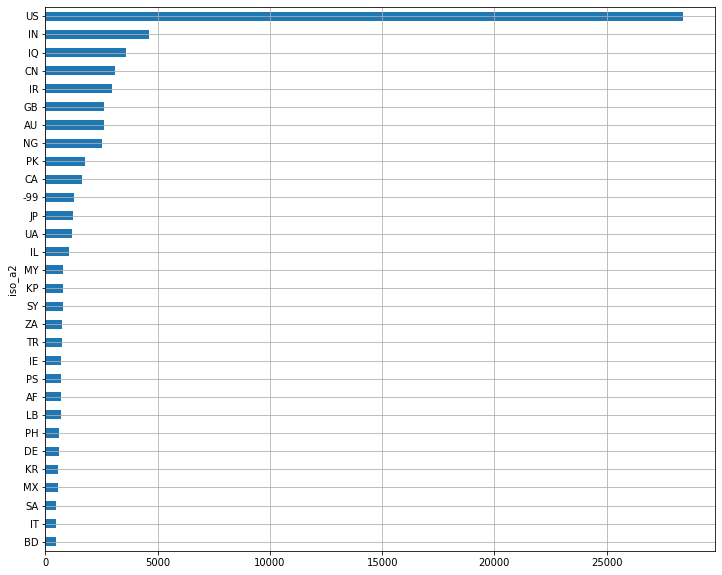

In [31]:
df_plot = df.set_index('iso_a2')['cnt'].sort_values(ascending=False)[:30][::-1]
df_plot.plot(kind='barh', figsize=(12, 10), grid=True);